### The dataset is proccessed before and columns that have unique values are taken in features to avoid the delay and memory usage for loading the data to train and test dataframe.

In [1]:
import os
import json
import gc
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn import model_selection, preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns

category_cols = list()
numeric_cols = list()

def loading_data_sets(csv_path='../input/train.csv',nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    load_dataframe = pd.read_csv(csv_path, sep=',',
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
            column_as_df = json_normalize(load_dataframe[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            load_dataframe = load_dataframe.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        print(f"Loaded {os.path.basename(csv_path)}. Shape: {load_dataframe.shape}")
    return load_dataframe

### Loading csv to dataframe

In [2]:
test_df = loading_data_sets('D:/KAGGLE/test_v2/test.csv')

Loaded test.csv. Shape: (401589, 59)


In [3]:
#test_df.head()
train_df = loading_data_sets('D:/KAGGLE/train_v2/train.csv')

Loaded train.csv. Shape: (1708337, 59)


In [4]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'totals.timeOnSite',
 'customDimensions',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [5]:
cols_to_drop = const_cols

In [6]:
train_df = train_df.drop(cols_to_drop , axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [8]:
train_df.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,...,1,1,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,...,NaN,2,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,...,1,2,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,...,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,...,1,2,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


#### Here train column has many object type so we need to convert to specific type

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 29 columns):
channelGrouping               object
date                          int64
fullVisitorId                 object
visitId                       int64
visitNumber                   int64
visitStartTime                int64
device.browser                object
device.deviceCategory         object
device.isMobile               bool
device.operatingSystem        object
geoNetwork.city               object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.region             object
geoNetwork.subContinent       object
totals.bounces                object
totals.hits                   object
totals.newVisits              object
totals.pageviews              object
totals.transactionRevenue     object
trafficSource.adContent       object
trafficSource.campaign        object
traff

#### Convert revenue column from obj to float type

In [10]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
groupdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

In [11]:
groupdf['totals.transactionRevenue'].unique().tolist()[:5]

[0.0, 33590000.0, 9490000.0, 79990000.0, 96350000.0]

### Finding number of unique visitors in both train and test sets

In [7]:
print("unique visitors in train set : ",train_df.fullVisitorId.nunique())
print("unique visitors in test set : ",test_df.fullVisitorId.nunique())
print("common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

unique visitors in train set :  1323730
unique visitors in test set :  296530
common visitors in train and test set :  2759


### Function for finding the missing values in the columns of the dataframe and finding its percentage 

In [14]:
def values_missing(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) 
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) 
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) 
    # Returning values of nulls different of 0(i.e nan values) as total contains nan values here.    
    print("\n Total of Sales % of Total: ", round((data['totals.transactionRevenue'].count() / len(data['totals.transactionRevenue']) * 100),4))
    #or we can use data[~np.isnan(data['totals.transactionRevenue'])] for getting non nan values
    
    return

#### Here we can see that transactionRevenue has 98.9% of null values...and hence the 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

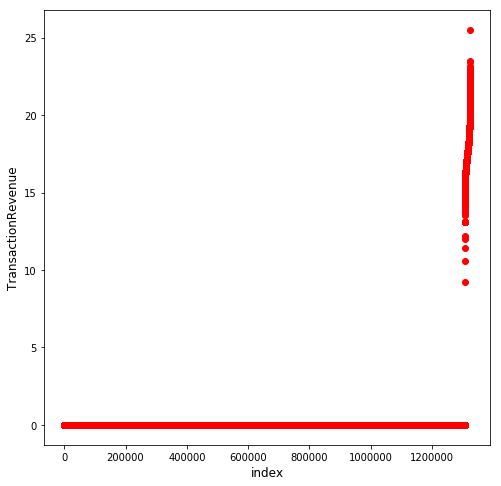

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(range(groupdf.shape[0]), np.sort(np.log1p(groupdf["totals.transactionRevenue"].values)),color='red')
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [16]:
values_missing(train_df)

Total columns at least one Values: 
                              Total    Percent
totals.transactionRevenue   1689823  98.916256
trafficSource.adContent     1643600  96.210525
trafficSource.isTrueDirect  1173819  68.711209
trafficSource.referralPath  1142073  66.852910
trafficSource.keyword       1052780  61.626014
totals.bounces               836759  48.980910
totals.newVisits             400907  23.467676
totals.pageviews                239   0.013990

 Total of Sales % of Total:  1.0837


In [17]:
#groupdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index() 
non_rev_c = groupdf[groupdf['totals.transactionRevenue']==0]#has rev column that are 0
#rev_gen_c = groupdf[groupdf['totals.transactionRevenue']>0]#has rev column that are above 0
print("The number of nonrevenue customers are ", len(non_rev_c))
print("The number of revenue generating customers are ",nonzero_uniq)
print("the ratio of revenue generating customers are {0:0.4}%".format((nonzero_uniq)/len(groupdf)*100))

The number of nonrevenue customers are  1307589
The number of revenue generating customers are  16141
the ratio of revenue generating customers are 1.219%


##### Fill the missing nan with 0 in rev column

In [21]:
train_df['totals.transactionRevenue'].fillna(0.0, inplace=True)

In [22]:
non_zero = train_df[train_df['totals.transactionRevenue']>0]['totals.transactionRevenue']

#### Applying log function on revenue column and ploting 

In [23]:
log_revenue = train_df["totals.transactionRevenue"].apply(np.log1p)

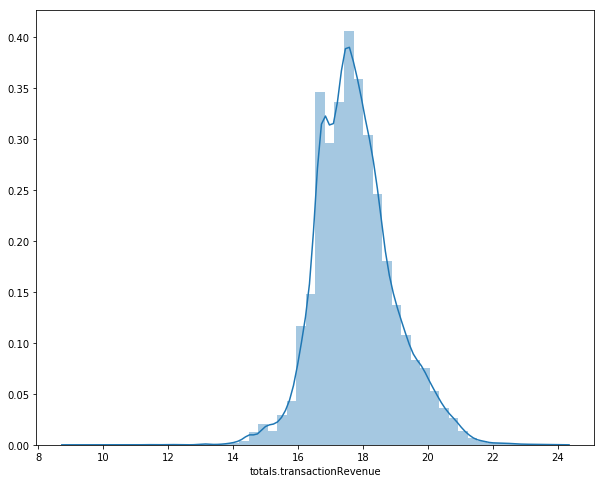

In [24]:
plt.figure(figsize=(10,8))
non_zero = log_revenue[log_revenue>0]
sns.distplot(non_zero)

In [25]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,...,1,1,0.0,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,...,NaN,2,0.0,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,...,1,2,0.0,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,...,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,...,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google


In [26]:
train_df.shape

(1708337, 29)

#### Extract the datetime format Using pandas

In [27]:
from datetime import datetime
#To convert into to readable date format to explore the changes in the rev generation
def processing_date(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    df["day"] = df['date'].day # extracting day
    df["weekday"] = df['date'].weekday #extracting week day
    df["month"] = df['date'].month # extracting day
    df["year"] = df['date'].year # extracting day
    
    return df

In [28]:
train_df = processing_date(train_df)
test_df = processing_date(test_df)

#### Exploring Date column in train data set

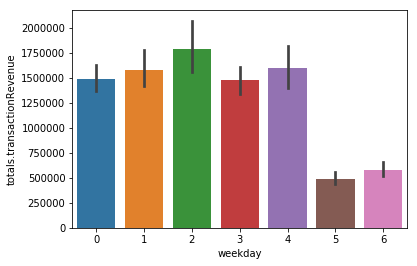

In [29]:
sns.barplot(x=train_df['weekday'], y=train_df['totals.transactionRevenue'], data=train_df)

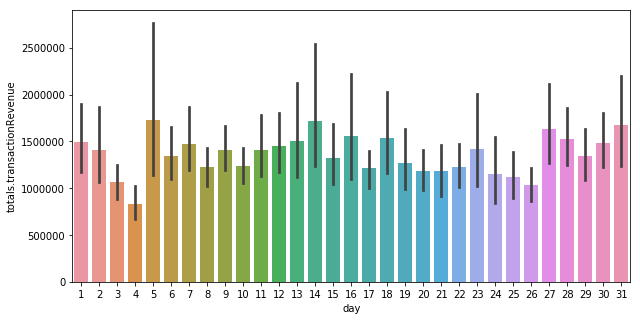

In [33]:
%matplotlib inline
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['day'], y=train_df['totals.transactionRevenue'] ,data=train_df)

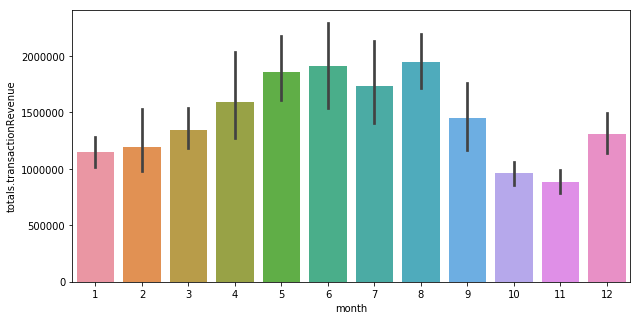

In [34]:
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['month'], y=train_df['totals.transactionRevenue'], data=train_df)

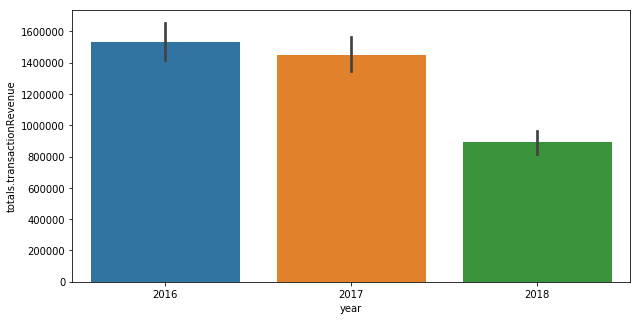

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['year'], y=train_df['totals.transactionRevenue'], data=train_df)

### From the above exploration we can make an inference that,
- During the starting and mid of the weekdays and mid of the year there is more revenue generation

In [36]:
train_df['date'].describe()

count                 1708337
unique                    638
top       2017-12-12 00:00:00
freq                     9234
first     2016-08-01 00:00:00
last      2018-04-30 00:00:00
Name: date, dtype: object

In [37]:
test_df['date'].describe()

count                  401589
unique                    168
top       2018-05-10 00:00:00
freq                     3884
first     2018-05-01 00:00:00
last      2018-10-15 00:00:00
Name: date, dtype: object

**<font color=blue>We can see that train set has data from Aug 1st 2016 to April 30th 2018</font><br>**
**<font color=red>Test set has data from May 1st 2018 to Oct 15th 2018</font>**

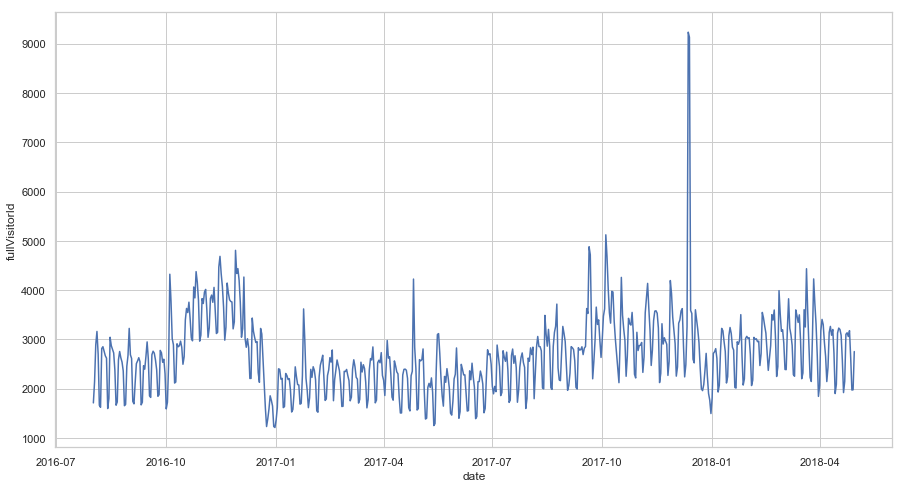

In [39]:
cnt_srs = train_df.groupby('date')['fullVisitorId'].size().reset_index()
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
sns.lineplot( cnt_srs['date'],cnt_srs['fullVisitorId'], markers=True, dashes=False)

** - More customers have visited the store during nov to dec**

In [40]:
def ext_sub_column(category):
    l=list()
    for i in train_df.columns:
        if(i.casefold().startswith(category.casefold())):
            l.append(i)
        else:
            continue
    return l

In [41]:
def category_plots(col,height,width):
    sample = train_df.loc[:,[col, 'totals.transactionRevenue']]
    sample['totals.transactionRevenue'] = sample['totals.transactionRevenue'].replace(0.0, np.nan)
    cnt_srs = sample.groupby(col)['totals.transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean transaction value"]
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(height, width)) 
    plt.subplot(3,1,1)
    sns.barplot(x=cnt_srs['count'].head(10), y=cnt_srs.index[:10])
    plt.subplot(3,1,2)
    sns.barplot(x=cnt_srs['count of non-zero revenue'].head(10), y=cnt_srs.index[:10])
    plt.subplot(3,1,3)
    sns.barplot(x=cnt_srs['mean transaction value'].head(10), y=cnt_srs.index[:10])
#extact device,traffic columns
device_cols = ext_sub_column('device')

traffic_cols = ext_sub_column('trafficSource')
train_df[traffic_cols].nunique(dropna=False)


trafficSource.adContent         77
trafficSource.campaign          33
trafficSource.isTrueDirect       2
trafficSource.keyword         4547
trafficSource.medium             7
trafficSource.referralPath    3197
trafficSource.source           345
dtype: int64

In [42]:
device_cols

['device.browser',
 'device.deviceCategory',
 'device.isMobile',
 'device.operatingSystem']

                         count  count of non-zero revenue  \
device.operatingSystem                                      
Windows                 619720                       3571   
Macintosh               438514                      10354   
Android                 299386                        753   
iOS                     219334                        832   
Linux                    63971                       1300   
Chrome OS                51318                       1703   
(not set)                11815                          0   
Windows Phone             1675                          1   
Samsung                    911                          0   
Tizen                      709                          0   

                        mean transaction value  
device.operatingSystem                          
Windows                           1.610381e+08  
Macintosh                         1.270264e+08  
Android                           6.670659e+07  
iOS                   

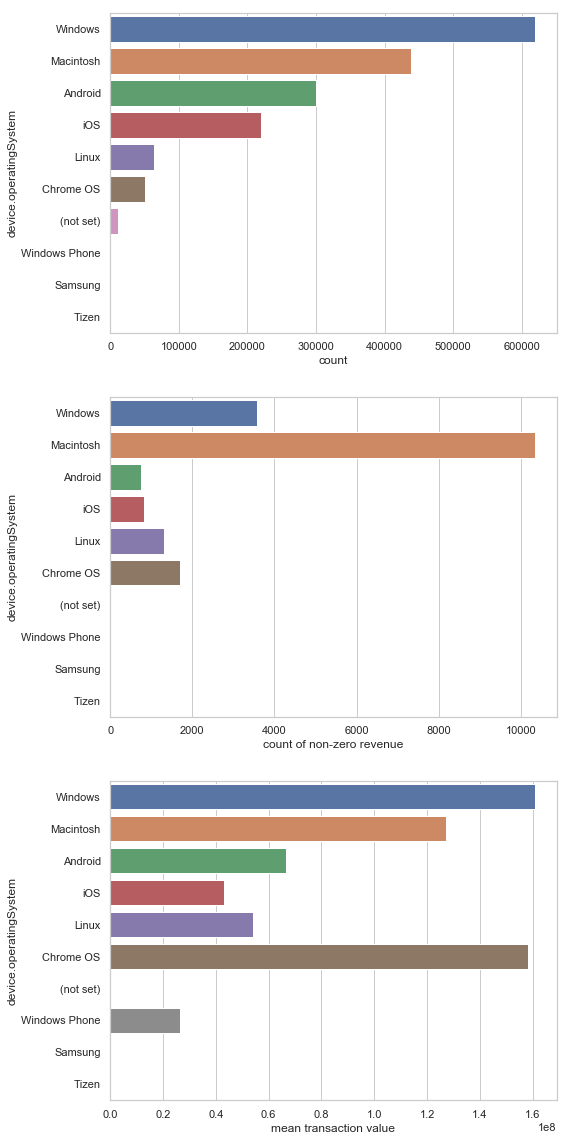

In [45]:
category_plots('device.operatingSystem',8,20)

** Inference **
> - Even though the count of Chrome os user is less, the revenue generated is more per individual than any other OS users.
> - overall Chrome OS, Windows,Macintosh users are producing majority revenue.

                         count  count of non-zero revenue  \
device.deviceCategory                                       
desktop                1171579                      16905   
mobile                  471336                       1364   
tablet                   65422                        245   

                       mean transaction value  
device.deviceCategory                          
desktop                          1.318602e+08  
mobile                           5.447116e+07  
tablet                           5.285339e+07  


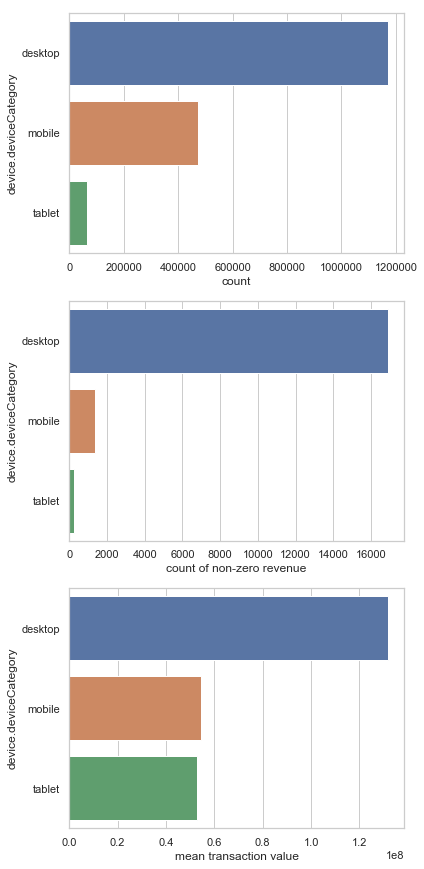

In [46]:
category_plots('device.deviceCategory',6,15)

** Inference **
> - Desktop users as well as the revenue generated from them is more compared to others.

                     count  count of non-zero revenue  mean transaction value
device.browser                                                               
Chrome             1173056                      16697            1.238645e+08
Safari              312165                       1210            6.338925e+07
Firefox              63845                        339            4.432043e+08
Internet Explorer    35474                        148            8.079703e+07
Android Webview      34266                         10            1.861100e+07
Edge                 20543                         74            1.090176e+08
Samsung Internet     15792                          8            2.760625e+07
Opera Mini           15018                          0                     NaN
Safari (in-app)      14207                         12            1.281417e+07
Opera                 9585                         14            4.248357e+07


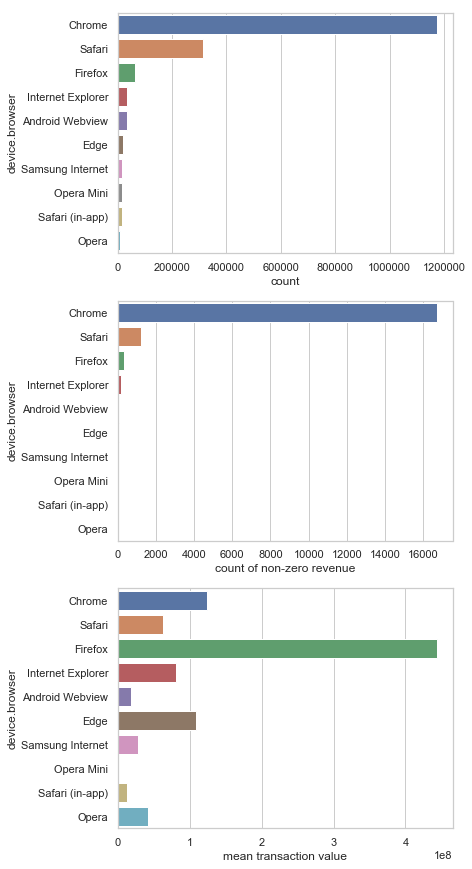

In [47]:
category_plots('device.browser',6,15)

** Inference **
> - The Mean transaction value is more for firefox but total mojority reveue is generated by windows users as more count is there.

##### Exploring traffic Source category


In [48]:
traffic_cols = ext_sub_column('trafficSource')

In [49]:
traffic_cols

['trafficSource.adContent',
 'trafficSource.campaign',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

                                count  count of non-zero revenue  \
trafficSource.adContent                                            
Google Merchandise Store        39566                          5   
Google Merchandise Collection    6762                        152   
Placement Accessores 300 x 250   3040                          5   
Smart display ad - 8/17/2017     2664                          0   
Display Ad created 3/11/14       2344                          9   
Google Online Store              1773                          6   
Official Google Merchandise       866                         25   
Ad from 12/15/17                  853                          0   
Full auto ad IMAGE ONLY           822                          5   
Placement Drinkware 300x250       653                          0   

                                mean transaction value  
trafficSource.adContent                                 
Google Merchandise Store                  2.510200e+07  
Google Merch

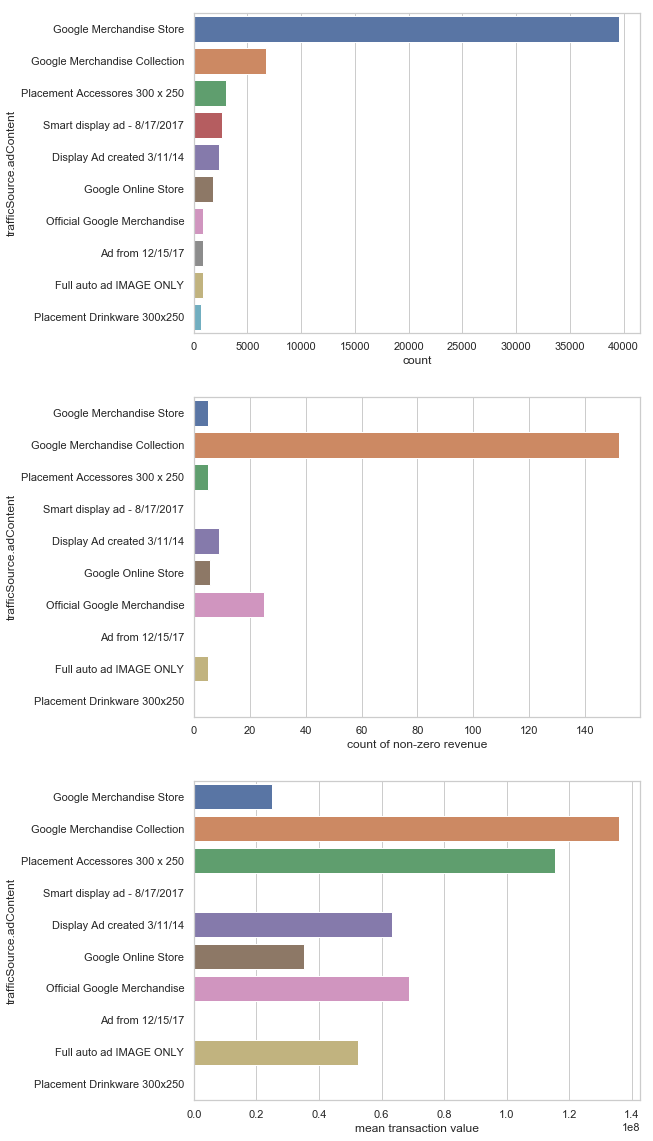

In [50]:
category_plots('trafficSource.adContent',8,20)

** Inference **
> - Google Merchandise Store is generating more rev, followed by Official google merchandise etc. 

                       count  count of non-zero revenue  \
trafficSource.source                                      
google                658384                       4683   
(direct)              565975                      13144   
youtube.com           329450                         25   
analytics.google.com   37436                          3   
Partners               32931                         17   
sites.google.com        9072                         76   
google.com              8341                         14   
m.facebook.com          6737                          7   
dfa                     6704                        137   
baidu                   4971                          0   

                      mean transaction value  
trafficSource.source                          
google                          1.001894e+08  
(direct)                        1.282169e+08  
youtube.com                     2.337640e+07  
analytics.google.com            7.823333e+06  
Partners 

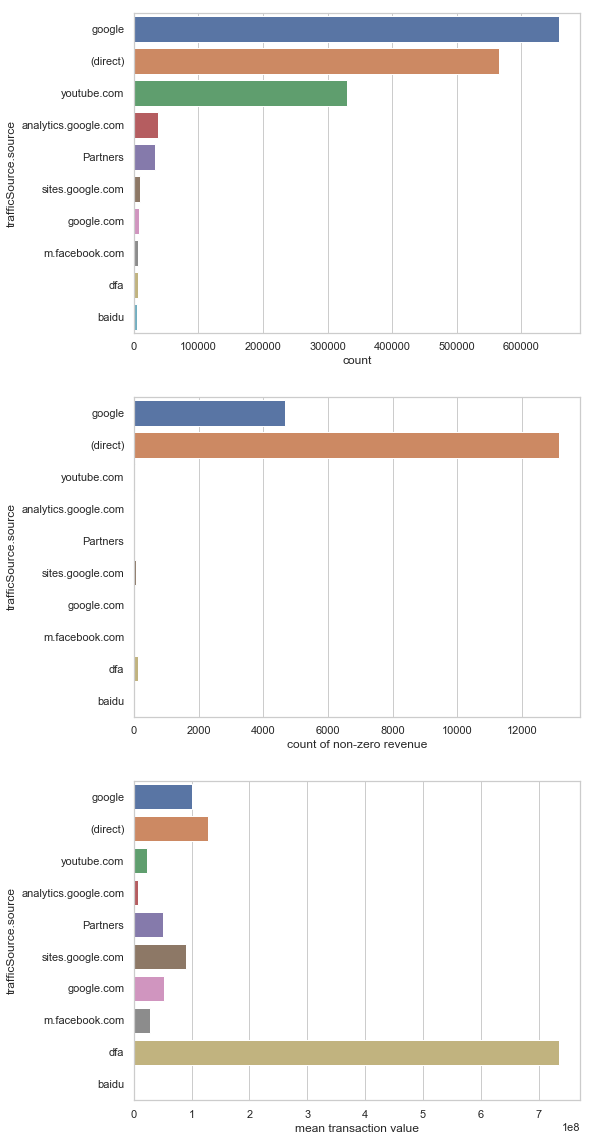

In [51]:
category_plots('trafficSource.source',8,20)

** Inference **
> - From this source column we see that google and through direct source more rev is generated

In [52]:
Geonetwork_clos = ext_sub_column('geoNetwork')

In [53]:
train_df[Geonetwork_clos].nunique(dropna=False)

geoNetwork.city               956
geoNetwork.continent            6
geoNetwork.country            228
geoNetwork.metro              123
geoNetwork.networkDomain    41982
geoNetwork.region             483
geoNetwork.subContinent        23
dtype: int64

#### let us do EDA with geoNetwork.country,geoNetwork.networkDomain,geoNetwork.continent            

                           count  count of non-zero revenue  \
geoNetwork.networkDomain                                      
(not set)                 499049                      10867   
unknown.unknown           269796                        665   
comcast.net                55486                       1505   
rr.com                     28715                        588   
verizon.net                26547                        755   
ttnet.com.tr               17078                          1   
comcastbusiness.net        16826                        454   
hinet.net                  15933                         17   
virginm.net                12594                          1   
cox.net                    10722                        236   

                          mean transaction value  
geoNetwork.networkDomain                          
(not set)                           1.201659e+08  
unknown.unknown                     8.759997e+07  
comcast.net                         1.1

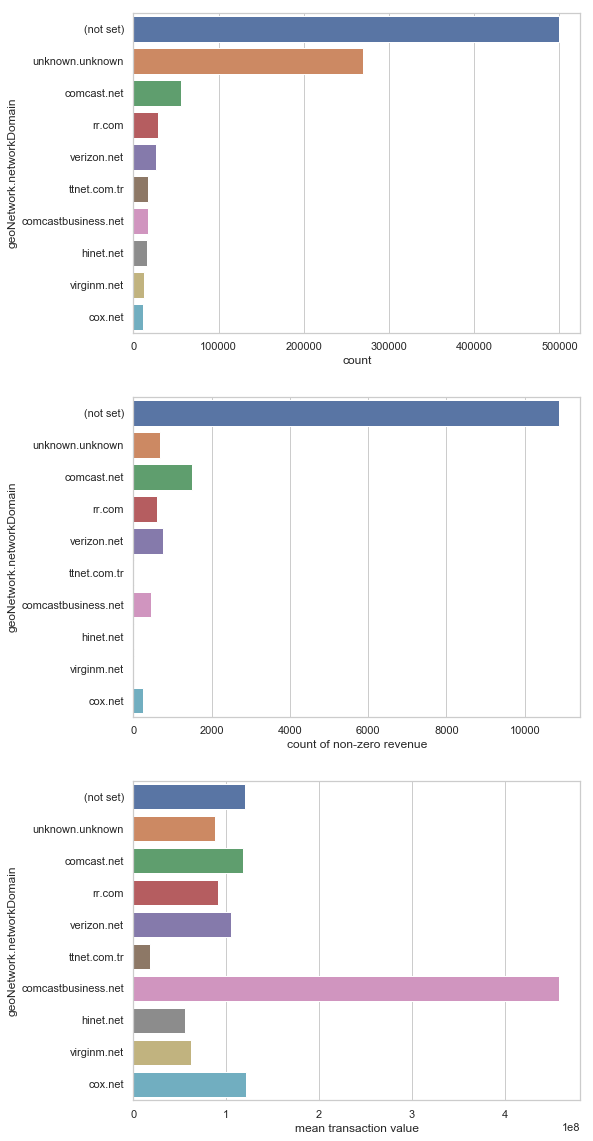

In [54]:
category_plots('geoNetwork.networkDomain',8,20) 

                       count  count of non-zero revenue  \
geoNetwork.continent                                      
Americas              877403                      18150   
Asia                  396719                        190   
Europe                368037                        126   
Africa                 35481                         12   
Oceania                28180                         29   
(not set)               2517                          7   

                      mean transaction value  
geoNetwork.continent                          
Americas                        1.247988e+08  
Asia                            1.231459e+08  
Europe                          8.926548e+07  
Africa                          7.521658e+08  
Oceania                         2.338310e+08  
(not set)                       1.136029e+08  


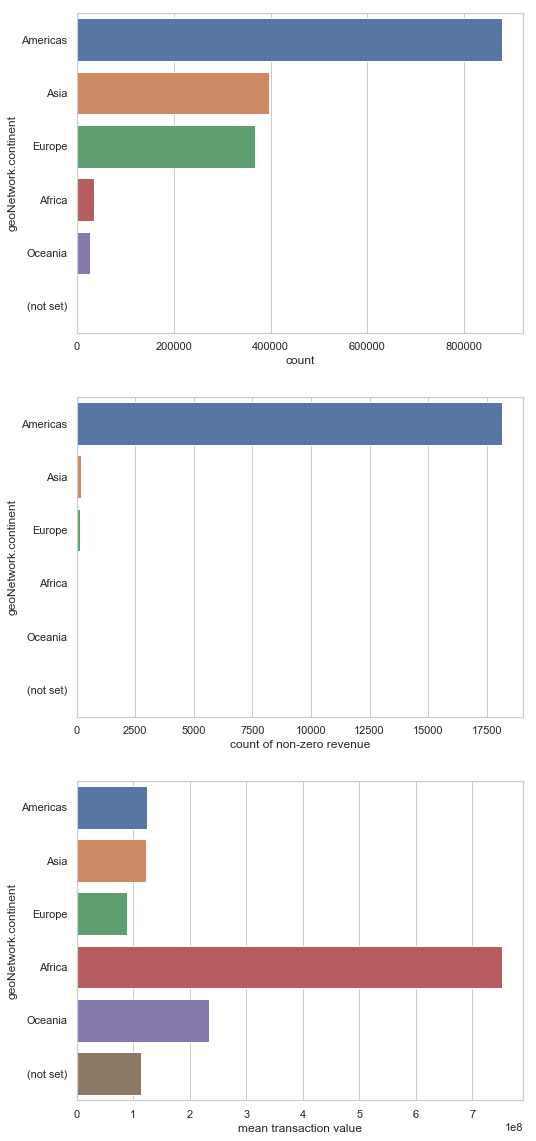

In [55]:
category_plots('geoNetwork.continent',8,20)

** Inference **
> - Americans contribute mojority reveue Here from the above visualisation.

                     count  count of non-zero revenue  mean transaction value
geoNetwork.country                                                           
United States       717217                      17658            1.244697e+08
India               105317                         18            7.425056e+07
United Kingdom       73341                         25            9.900160e+07
Canada               51057                        315            1.355531e+08
Germany              38516                         12            6.402000e+07
Japan                36637                         22            3.346136e+08
Brazil               35432                         21            9.631952e+07
Vietnam              34869                          0                     NaN
France               32289                         11            9.733545e+07
Thailand             29859                         10            6.141600e+07


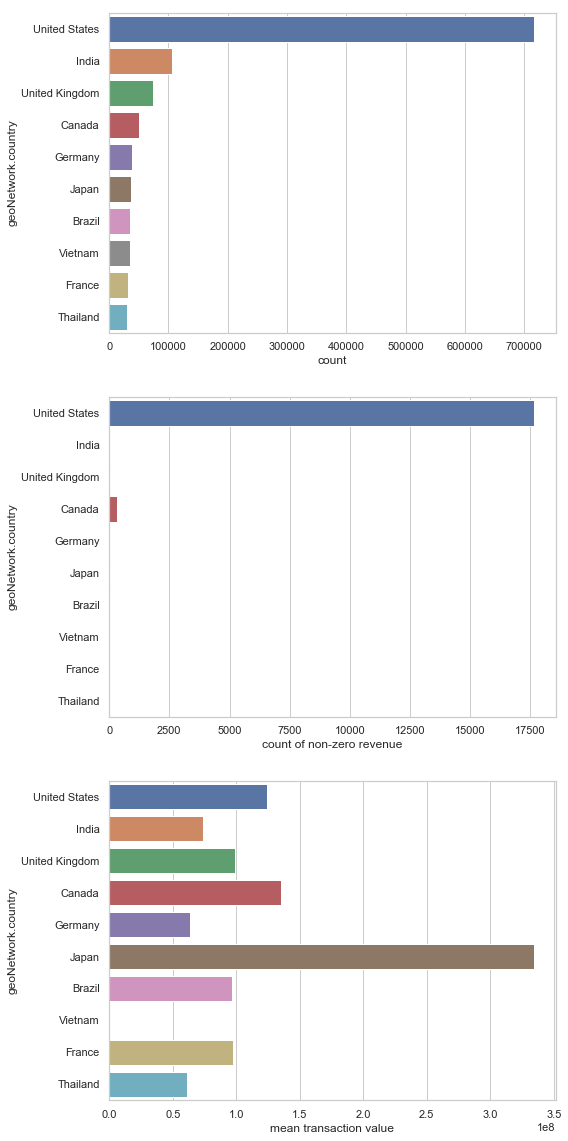

In [56]:
category_plots('geoNetwork.country',8,20)

In [58]:
def total_col_plots(col):
    a = train_df.loc[:,[col, 'totals.transactionRevenue']]
    a['totals.transactionRevenue'] = a['totals.transactionRevenue'].replace(0.0, np.nan)
    cnt_srs = a.groupby(col)['totals.transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean"]
    cnt_srs['total_revenue'] = cnt_srs['count of non-zero revenue']*cnt_srs['mean']
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(15, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(y=cnt_srs['count'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,2)
    sns.barplot(y=cnt_srs['count of non-zero revenue'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,3)
    sns.barplot(y=cnt_srs['mean'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,4)
    sns.barplot(y=cnt_srs['total_revenue'].head(50), x=list(range(1,51)))

In [59]:
train_df.dtypes

channelGrouping                       object
date                          datetime64[ns]
fullVisitorId                         object
visitId                                int64
visitNumber                            int64
visitStartTime                         int64
device.browser                        object
device.deviceCategory                 object
device.isMobile                         bool
device.operatingSystem                object
geoNetwork.city                       object
geoNetwork.continent                  object
geoNetwork.country                    object
geoNetwork.metro                      object
geoNetwork.networkDomain              object
geoNetwork.region                     object
geoNetwork.subContinent               object
totals.bounces                        object
totals.hits                           object
totals.newVisits                      object
totals.pageviews                      object
totals.transactionRevenue            float64
trafficSou

**creating category_cols that are of type object in train data set**

In [4]:
category_cols.extend(['channelGrouping', 'fullVisitorId', 'device.browser', 'device.deviceCategory',
    'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain',
    'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword',
    'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source'])


In [46]:
len(category_cols)

19

In [47]:
train_df[category_cols].nunique(dropna=False)
#here we are removing the fullvistorId as it is int type
category_cols.remove('fullVisitorId')
#we are appending the bool column of is mobile to category_cols
category_cols.append('device.isMobile')

In [51]:
numeric_cols.extend(['visitNumber', 'totals.transactionRevenue', 'weekday', 'day', 'month', 'visitHour',
 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews'])
numeric_cols

['visitNumber',
 'totals.transactionRevenue',
 'weekday',
 'day',
 'month',
 'visitHour',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews']

In [52]:
train_df[numeric_cols].isnull().sum()

visitNumber                       0
totals.transactionRevenue         0
weekday                           0
day                               0
month                             0
visitHour                         0
totals.bounces               836759
totals.hits                       0
totals.newVisits             400907
totals.pageviews                239
dtype: int64

** Filling the nan values with specific data for evaluation **

In [53]:
#fill the nan values with 0 for train and test sets
train_df['totals.bounces'] = train_df['totals.bounces'].fillna(0)
test_df['totals.bounces'] = test_df['totals.bounces'].fillna(0)

train_df['totals.newVisits'] = train_df['totals.newVisits'].fillna(0)
test_df['totals.newVisits'] = test_df['totals.newVisits'].fillna(0)

train_df['totals.pageviews'] = train_df['totals.pageviews'].fillna(1)
test_df['totals.pageviews'] = test_df['totals.pageviews'].fillna(1)
train_df[numeric_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 10 columns):
visitNumber                  int64
totals.transactionRevenue    float64
weekday                      int64
day                          int64
month                        int64
visitHour                    int32
totals.bounces               object
totals.hits                  object
totals.newVisits             object
totals.pageviews             object
dtypes: float64(1), int32(1), int64(4), object(4)
memory usage: 123.8+ MB


In [54]:
#convert from the string type to the int type in both test and train sets
for col in ['totals.bounces', 'totals.hits', 'totals.newVisits','totals.pageviews' ]:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)
train_df[numeric_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 10 columns):
visitNumber                  int64
totals.transactionRevenue    float64
weekday                      int64
day                          int64
month                        int64
visitHour                    int32
totals.bounces               int32
totals.hits                  int32
totals.newVisits             int32
totals.pageviews             int32
dtypes: float64(1), int32(5), int64(4)
memory usage: 97.8 MB


In [55]:
category_col_null = train_df[category_cols].isnull().sum()
category_col_null_percent= category_col_null/len(train_df)*100
category_col_null_percent

channelGrouping                0.000000
device.browser                 0.000000
device.deviceCategory          0.000000
device.operatingSystem         0.000000
geoNetwork.city                0.000000
geoNetwork.continent           0.000000
geoNetwork.country             0.000000
geoNetwork.metro               0.000000
geoNetwork.networkDomain       0.000000
geoNetwork.region              0.000000
geoNetwork.subContinent        0.000000
trafficSource.adContent       96.210525
trafficSource.campaign         0.000000
trafficSource.isTrueDirect    68.711209
trafficSource.keyword         61.626014
trafficSource.medium           0.000000
trafficSource.referralPath    66.852910
trafficSource.source           0.000000
device.isMobile                0.000000
dtype: float64

In [56]:
#here we fill bool column for nan with false and reflecting in the original dataset
train_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

#fill nan with unknown value for better model prediction.
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    train_df[col].fillna('unknown', inplace=True)
    test_df[col].fillna('unknown', inplace=True)
train_df.shape
train_df.isnull().sum()
#counting the number of null values in train dataframe

channelGrouping               0
date                          0
fullVisitorId                 0
visitId                       0
visitNumber                   0
visitStartTime                0
device.browser                0
device.deviceCategory         0
device.isMobile               0
device.operatingSystem        0
geoNetwork.city               0
geoNetwork.continent          0
geoNetwork.country            0
geoNetwork.metro              0
geoNetwork.networkDomain      0
geoNetwork.region             0
geoNetwork.subContinent       0
totals.bounces                0
totals.hits                   0
totals.newVisits              0
totals.pageviews              0
totals.transactionRevenue     0
trafficSource.adContent       0
trafficSource.campaign        0
trafficSource.isTrueDirect    0
trafficSource.keyword         0
trafficSource.medium          0
trafficSource.referralPath    0
trafficSource.source          0
weekday                       0
day                           0
month   

In [84]:
train_df.to_csv('D:\\KAGGLE\\PROCESSED_TRAIN.csv',index=False)
test_df.to_csv('D:\\KAGGLE\\PROCESSED_TEST.csv',index=False)

In [7]:
#processed_test_list=list(test_df)
#processed_test_list
test_proccessed=pd.read_csv('D:\\KAGGLE\\PROCESSED_TEST.csv')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
test_proccessed.shape

(401589, 34)

In [6]:
train_proccessed=pd.read_csv('D:\\KAGGLE\\PROCESSED_TRAIN.csv')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 34 columns):
channelGrouping               401589 non-null object
date                          401589 non-null datetime64[ns]
fullVisitorId                 401589 non-null object
visitId                       401589 non-null int64
visitNumber                   401589 non-null int64
visitStartTime                401589 non-null int64
device.browser                401589 non-null object
device.deviceCategory         401589 non-null object
device.isMobile               401589 non-null bool
device.operatingSystem        401589 non-null object
geoNetwork.city               401589 non-null object
geoNetwork.continent          401589 non-null object
geoNetwork.country            401589 non-null object
geoNetwork.metro              401589 non-null object
geoNetwork.networkDomain      401589 non-null object
geoNetwork.region             401589 non-null object
geoNetwork.subContinent       401589 n

In [9]:
test_proccessed['date']=test_proccessed['date'].values.astype('datetime64[ns]')

In [10]:
train_proccessed.shape

(1708337, 34)

In [11]:
train_proccessed['date']=train_proccessed['date'].values.astype('datetime64[ns]')

In [12]:
train_proccessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 34 columns):
channelGrouping               object
date                          datetime64[ns]
fullVisitorId                 object
visitId                       int64
visitNumber                   int64
visitStartTime                int64
device.browser                object
device.deviceCategory         object
device.isMobile               bool
device.operatingSystem        object
geoNetwork.city               object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.region             object
geoNetwork.subContinent       object
totals.bounces                int64
totals.hits                   int64
totals.newVisits              int64
totals.pageviews              int64
totals.transactionRevenue     float64
trafficSource.adContent       object
trafficSource.campaign        object

In [20]:
train_new = train_d.copy()
test_new = test_df.copy()

**Before performing label encoding, we merge the test and train sets to insure we have consistent labels in the two sets:**

In [23]:
from sklearn.preprocessing import LabelEncoder
for col in category_cols:
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_new[col],test_new[col]]).astype("str"))
    train_new[col] = lbe.transform(train_new[col].astype("str"))
    test_new[col] = lbe.transform(test_new[col].astype("str"))

In [78]:
train_new.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,day,month,year,visitHour
0,4,2017-10-16,3162355547410993243,1508198450,1,1508198450,64,0,0,22,...,0,3761,5,3757,117,0,16,10,2017,5
1,6,2017-10-16,8934116514970143966,1508176307,6,1508176307,55,0,0,3,...,0,3709,6,339,339,0,16,10,2017,23
2,2,2017-10-16,7992466427990357681,1508201613,1,1508201613,55,1,1,1,...,1,3709,0,3757,0,0,16,10,2017,6
3,4,2017-10-16,9075655783635761930,1508169851,1,1508169851,55,0,0,22,...,0,8,5,3757,117,0,16,10,2017,21
4,4,2017-10-16,6960673291025684308,1508190552,1,1508190552,55,0,0,22,...,0,8,5,3757,117,0,16,10,2017,3


In [79]:
test_new.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,day,month,year,visitHour
0,4,2018-05-11,7460955084541987166,1526099341,2,1526099341,55,1,1,1,...,1,8,5,0,117,4,11,5,2018,9
1,2,2018-05-11,460252456180441002,1526064483,166,1526064483,55,0,0,7,...,1,9,0,0,0,4,11,5,2018,0
2,4,2018-05-11,3461808543879602873,1526067157,2,1526067157,55,0,0,3,...,1,8,5,0,117,4,11,5,2018,1
3,2,2018-05-11,975129477712150630,1526107551,4,1526107551,55,1,1,25,...,1,9,0,0,0,4,11,5,2018,12
4,4,2018-05-11,8381672768065729990,1526060254,1,1526060254,71,2,1,22,...,0,8,5,0,117,4,11,5,2018,23


**Here test_x has the features for predicting the test_y values.**

In [82]:
train_X = train_new[category_cols+numeric_cols]
train_Y = train_new['totals.transactionRevenue']

In [83]:
test_X = test_new[category_cols+numeric_cols]
test_Y = test_new['totals.transactionRevenue']

In [84]:
test_X.head()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,...,device.isMobile,visitNumber,weekday,day,month,visitHour,totals.bounces,totals.hits,totals.newVisits,totals.pageviews
0,4,55,1,1,1,3,93,0,44691,126,...,1,2,4,11,5,9,0,4,0,3
1,2,55,0,7,858,2,219,104,0,74,...,0,166,4,11,5,0,0,4,0,3
2,4,55,0,3,1096,2,219,129,31310,517,...,0,2,4,11,5,1,0,4,0,3
3,2,55,1,25,417,2,219,48,0,462,...,1,4,4,11,5,12,0,5,0,4
4,4,71,2,22,432,2,219,64,8820,74,...,1,1,4,11,5,23,0,5,1,4


In [85]:
train_Y = train_Y.apply(np.log1p)

In [87]:
train_new['date'].describe()

count                 1708337
unique                    638
top       2017-12-12 00:00:00
freq                     9234
first     2016-08-01 00:00:00
last      2018-04-30 00:00:00
Name: date, dtype: object

** Here we take the data above 2018-3-30 for checking validation **

In [88]:
from datetime import date

val_df = train_new[train_new['date']>='2018-3-30']
val_X = val_df[category_cols+numeric_cols]
val_Y = val_df['totals.transactionRevenue']

In [89]:
dev_df = train_new[train_new['date']<'2018-3-30']
train_X = dev_df[category_cols+numeric_cols]
train_Y = dev_df['totals.transactionRevenue']

In [90]:
train_Y = train_Y.apply(np.log1p)
val_Y = val_Y.apply(np.log1p)
val_X.head()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,...,device.isMobile,visitNumber,weekday,day,month,visitHour,totals.bounces,totals.hits,totals.newVisits,totals.pageviews
17047,4,55,0,22,858,2,219,104,8906,74,...,0,7,6,15,4,3,0,3,0,3
17048,2,64,0,22,1096,2,219,129,38476,517,...,0,1,6,15,4,1,0,3,1,3
17049,1,102,1,25,536,2,219,64,36819,74,...,1,1,6,15,4,2,0,3,1,3
17050,3,55,1,1,1096,3,93,129,44691,517,...,1,3,6,15,4,5,0,3,0,3
17051,2,55,0,22,601,3,102,52,0,470,...,0,1,6,15,4,10,0,3,1,3


ytjtjytjtttttttttttttttttttttttttttt

In [92]:
# custom function to run light gbm model
import lightgbm as lgb
params = { 
        "objective" : "regression",
        "boosting_type" : 'dart',
        "metric" : "rmse", 
        "num_leaves" : 60,
        "min_child_samples" : 100,
        "learning_rate" : 0.03,
        "bagging_fraction" : 0.8,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 200,
        "verbosity" : 100
    }

LGBM_train = lgb.Dataset(train_X, label=train_Y,categorical_feature=category_cols)
LGBM_valid = lgb.Dataset(val_X, label=val_Y,categorical_feature=category_cols)
LGBM_model = lgb.train(params, LGBM_train, 2000, valid_sets=[LGBM_valid], early_stopping_rounds=150, verbose_eval=100)
predicted_test = LGBM_model.predict(test_X, num_iteration=LGBM_model.best_iteration)
predicted_val = LGBM_model.predict(val_X, num_iteration=LGBM_model.best_iteration)

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.37984
[200]	valid_0's rmse: 1.37146
[300]	valid_0's rmse: 1.36936
[400]	valid_0's rmse: 1.37057
Early stopping, best iteration is:
[340]	valid_0's rmse: 1.36839


**Now let us compute the evaluation metric on the validation data. So we need to do a sum for all the transactions of the user and then do a log transformation on top. And make the values less than 0 to 0 as transaction revenue can only be 0 or more.**

In [94]:
from sklearn import metrics
predicted_val[predicted_val<0] = 0
pred_df_val = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
pred_df_val["transactionRevenue"] = val_df["totals.transactionRevenue"].values
pred_df_val["PredictedRevenue"] = np.expm1(predicted_val)
pred_df_val = pred_df_val.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(pred_df_val["transactionRevenue"].values), np.log1p(pred_df_val["PredictedRevenue"].values))))
'''1.4855904993409212 1.4494322142023286 1.4456313062463275'''

1.4423024928840236


'1.4855904993409212 1.4494322142023286 1.4456313062463275'

**Improvements after tuning the parameters of the light gbm**

**Creating a submission file**

In [97]:
id = test_df['fullVisitorId']
submit = pd.DataFrame({"fullVisitorId":id})
predicted_test[predicted_test<0] = 0
submit["PredictedLogRevenue"] = np.expm1(predicted_test)
submit = submit.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submit.columns = ["fullVisitorId", "PredictedLogRevenue"]
submit["PredictedLogRevenue"] = np.log1p(submit["PredictedLogRevenue"])
submit.to_csv("D:\\Sub_file.csv", index=False)

In [98]:
submit.shape

(296530, 2)